<h1> Feature engineering <br>
Modelling <br>
and Evaluation</h2>
<br>
<br>
<b> This is work in progress! </b> <p> Next up is making the pipeline more automated. Scaling the targets. And finetune  the  LSTM, which architeture should it have. How many lags, how many LSTM units, how many  layers, how many perceptrons, which activation functions, and which special layers to add to the architecture. 
<br>
<br>
Radical change: use NIBOR in stead of interest rate, because it is update daily and can give better results.
<h4> Readying the forecast dataset </h4>
Use Ohrnstein Uhlenbeck process to find Food_index price. Use SSB/NB to find forecasts for policy rate. Find some forecasts or eventually use OU-process to find the FX.

<!-- <ol>
<li>Deterministic process</li>
<li>Lagged variables</li>
<li> Fourier</li>
<li>Seasonal indicators (very important)</li>
<li></li>
<li></li>
<li></li>
</ol> -->

<h1> 1. Getting started </h1>
<h2> 1.1 Importing libraries </h2>

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

import random
from keras import regularizers
import keras_tuner 
import keras

import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, Input, callbacks
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.optimizers import RMSprop, Adam


from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import  CalendarFourier

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from keras.callbacks import EarlyStopping


<h2> 1.2 Downloading data </h2>

In [24]:
df = pd.read_csv('Preprocessed_data.csv')
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop(['Date'], axis=1, inplace=True)

<h2> 1.3 Splitting data in 3*2 </h2>
<p> SPlitting data into train, test and validation with the following split: 70 | 15 |15.

In [25]:
y = df['Salmon_exp_vol']
X = df.loc[:,'FX_EURONOK':]

X_train, X_eval, y_train, y_eval = train_test_split(X,y, 
                                                    test_size=0.2,
                                                    shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, 
                                                test_size=0.5,
                                                shuffle=False)

<h1> 2. Feature engineering </h1>

<h2> 2.1 Manual imputing </h2>
<p>  Manually fixing NaN, and wrongful observations from the dataset in the training data. </p>

In [26]:
X_train['FX_EURONOK']['2002-10-14'] = 7.34
X_train['FX_EURONOK']['2008-08-04'] = 7.9995
X_train['FX_EURONOK']['2008-08-08'] = 7.9915
X_train['FX_EURONOK']['2008-08-11'] = 7.9975
X_train['FX_EURONOK']['2008-08-18'] = 7.9740

<h2> 2.2 Time dummy and Fourier  </h2>
<p> Creating a time dummy variable. Adding one new colum, where the value goes from 0 to the amount of observations. </p>

In [27]:
def det_process(X, startValue=None):
    # fourier0  =  CalendarFourier(freq='A',  order=3)
    # fourier1  =  CalendarFourier(freq='6M',  order=3)
    # fourier2  =  CalendarFourier(freq='Q',  order=3)

    dp = DeterministicProcess(
        index=X.index,
        constant=True,
        order=1,
        # seasonal=True,
        # additional_terms=[fourier0,fourier1,fourier2],
        drop=True
    ) 
    dp = dp.in_sample()
    dp['trend'] += startValue
    new_X = pd.concat([X,dp], axis=1)
    return new_X
time_func = FunctionTransformer(func=det_process, 
                                kw_args={'startValue':None})


<h2> 2.3  Column specific engineering </h2>
<h3> 2.3.1 Log transformation </h3>
<p> Function for log transformation. The FOREX column shows specific characeristics from the lognormal distribution. 

In [28]:
def log_transformation(X):
    X = np.log1p(X)
    X = pd.DataFrame(X)
    return X
log_func = FunctionTransformer(func=log_transformation)

<h2> 2.4  Z-scoring </h2>
<p> Create functions for scaling the variables in a standardized way. </p>

In [29]:
zScore_func = StandardScaler()
zScoreTarget_func = StandardScaler()

<h3> 2.5 Lagged target variable

In [51]:
y_train

Date
2001-01-01     4089
2001-01-08     4959
2001-01-15     4610
2001-01-22     4470
2001-01-29     4523
              ...  
2019-04-22    16037
2019-04-29    16133
2019-05-06    16315
2019-05-13    16127
2019-05-20    18992
Name: Salmon_exp_vol, Length: 960, dtype: int64

In [50]:
y_train.shift(1)

Date
2001-01-01        NaN
2001-01-08     4089.0
2001-01-15     4959.0
2001-01-22     4610.0
2001-01-29     4470.0
               ...   
2019-04-22    12499.0
2019-04-29    16037.0
2019-05-06    16133.0
2019-05-13    16315.0
2019-05-20    16127.0
Name: Salmon_exp_vol, Length: 960, dtype: float64

In [43]:
def lagged_target(X,y):
    for i in range(2,5,1):
        new_col = y.shift(i)
        X['tar_lag_'+str(i)] = new_col
    return X
laggedTarget_func = FunctionTransformer(func=lagged_target,
                                        kw_args={'y':None})


<h2> 2.6 Seasonal indicators </h2>
<p> Creating dummy variables for each week in a year. So creating 52 new columns, on for each week. The values are 1 if the observations falls within that week, and zero if not. </p>

In [32]:
def seasonal_indicators(X):
    weeks = np.linspace(1,53,53)
    indicator_df = pd.DataFrame()
    for i in range(0,len(weeks),1):
        column = np.where(X.index.isocalendar().week==weeks[i],1,0)
        indicator_df['IndWeek'+str(i)] = column
    indicator_df.index = X.index
    new_X = pd.concat([X, indicator_df],axis=1)
    # new_X = pd.merge(X, indicator_df, 
    #                 left_index=True, right_index=True)
    return new_X
indicator_func = FunctionTransformer(func=seasonal_indicators)



<h2> 2.5 Reshaping 2d->3d array </h2>
Function for reshaping the dataset to include timesteps, and transform the data from being 2d to 3d </p>

In [33]:
def reshaper(X, timeSteps=None):
    X = pd.DataFrame(X)
    new_Xs = [np.array(X[timeSteps:])]

    for i in range(1, timeSteps+1,1):
        shift_X  = np.array(X.shift(i))
        new_Xs.append(shift_X[timeSteps:])
    # for i in range(1,timeSteps+1,1):
    #     shift_X  = np.array(X.shift(-i))
    #     new_Xs.append(shift_X[timeSteps:])

    X_reshaped = np.stack(new_Xs, axis=1)
    print(X_reshaped.shape)
    return X_reshaped

reshape_func = FunctionTransformer(func=reshaper, kw_args={'timeSteps':None})

<h1> 3. LSTM model </h1>

In [34]:
# np.random.seed(7)


# units = hp.Int(name='units', min_value=25, max_value= 250, step= 25)
# model = keras.Sequential([
#     layers.Input(shape=(14,109), name='input_layer'),
#     layers.LSTM(75, recurrent_dropout=0.5, return_sequences=True),
#     # layers.LSTM(150, recurrent_dropout=0.3, return_sequences=True),
#     # layers.LSTM(200, recurrent_dropout=0.3),
#     # layers.BatchNormalization(),
#     # layers.Dropout(0.5),
#     # layers.Dense(128, activation='relu'),
#     # layers.BatchNormalization(),
#     # layers.Dropout(0.3),
#     # layers.Dense(256, activation='relu'),
#     # layers.BatchNormalization(),
#     # layers.Dropout(0.5),
#     # layers.Dense(512, activation='gelu'),
#     # layers.Dropout(0.3),
#     # layers.Dense(256, activation='selu'),
#     # layers.Dropout(0.5),
#     layers.Dense(109, activation='relu'),
#     layers.Dense(1)
# ])


# optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate as needed
# model.compile(optimizer=optimizer,
#             #   loss=keras.losses.MeanSquaredError()
#               loss = 'mae'
#               )

# early_stopping = callbacks.EarlyStopping(
#     min_delta=0.001, 
#     patience=15, 
#     restore_best_weights=True,
# )

In [82]:
fdf

,FX_EURONOK,Interest_rate,Food_index
0,80.704000,4.50,80.704000
1,80.889830,4.50,81.085189
2,80.391662,4.50,81.347014
3,80.020059,4.50,81.222230
4,80.011545,4.50,81.121354
5,80.004285,4.50,80.804132
6,79.800839,4.50,80.643719
7,79.600528,4.50,80.361746
8,79.536697,4.50,80.129073
9,79.431857,4.50,80.076631


In [ ]:
X_forecast = pd.read_csv('forecast_df.csv')
X_forecast.index = pd.to_datetime(X_forecast['Date'], format='%Y-%m-%d')
X_forecast.drop(['Date'], axis=1, inplace=True)

<h1> 4.  Pipelining </h1>
<h2> 4.1 Column specific pipeline </h2>

In [35]:
engineering_func = ColumnTransformer(
    transformers=[
        ('loger', log_func, ['FX_EURONOK']),
    ], remainder='passthrough')

<h2> 4.2 Total pipeline </h2>

In [ ]:
X_val_corr = pd.concat([X_train[-13:],X_val])
X_test_corr = pd.concat([X_val[-13:],X_test])
X_forecast_corr = pd.concat([X_test[-13:],X_forecast])

In [109]:
pipe = Pipeline(steps=[
    ('det', time_func),
    ('ind', indicator_func),
    # ('lag', laggedTarget_func),
    ('Col_spec', engineering_func),
    ('zScore_func', zScore_func),
    ('res', reshape_func)
    # ('lstm', model)
])


pipe.set_params(
                det__kw_args={'startValue':0},
                # lag__kw_args={'y':y_train},
                res__kw_args={'timeSteps':13}
                )
X_train_preprocessed  = pipe.fit_transform(X_train)

pipe.set_params(det__kw_args={'startValue':959-13}, 
                # lag__kw_args={'y':y_val},
                res__kw_args={'timeSteps':13}
                )
X_val_preprocessed  = pipe.transform(X_val_corr)

pipe.set_params(det__kw_args={'startValue':1079-13}, 
                # lag__kw_args={'y': y_test},
                res__kw_args={'timeSteps':13}
                )
X_test_preprocessed  = pipe.transform(X_test_corr)


pipe.set_params(det__kw_args={'startValue':1200-13}, 
                # lag__kw_args={'y': y_test},
                res__kw_args={'timeSteps':13}
                )
X_fore_preprocessed  = pipe.transform(X_forecast_corr)

(947, 14, 58)
(120, 14, 58)
(120, 14, 58)
(52, 14, 58)


In [64]:
# target_scaler = StandardScaler()
# y_train_pre = target_scaler.fit_transform(np.array([y_train[14:]]).T)
# y_val_pre = target_scaler.transform(np.array([y_val[14:]]).T)
# y_test_pre = target_scaler.transform(np.array([y_test[14:]]).T)

y_train_pre = y_train[13:]
y_val_pre = y_val[:]
y_test_pre =y_test[:]

<h1> X. Rest are drafts.. </h1>

In [65]:
# def rolling_window_cross_val(model, metric):
#     X = np.concatenate((X_train_preprocessed,X_val_preprocessed),axis=0)
#     y = np.concatenate((y_train_pre,y_val_pre),axis=0)


#     scores = []
#     for i in range(0,3,1):
#         sel_X = X[int(i*0.316*X.shape[0]):int((i+1)*0.316*X.shape[0])]
#         sel_y = y[int(i*0.316*y.shape[0]):int((i+1)*0.316*y.shape[0])]

#         sel_X_test = X[int(i*(0.316+0.05)*X.shape[0]):int((i+1)*(0.316+0.05)*X.shape[0])]
#         sel_y_test = y[int(i*(0.316+0.05)*y.shape[0]):int((i+1)*(0.316+0.05)*y.shape[0])]
    
#         model.fit(sel_X,sel_y,
#                 epochs=500, batch_size=60,
#                 validation_data=[sel_X_test, sel_y_test],
#                 callbacks=early_stopping, verbose=False)        
#         pred = model.predict(sel_X_test)
#         score = metric(pred, sel_y_test)
#         scores.append(score)
    
#     return [np.mean(scores),model]

# cv_result = rolling_window_cross_val(model,  MAE)


<h1> Large tuner

In [66]:
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)

In [110]:
def build_model(hp):
    model = keras.Sequential([
        layers.Input(shape=(14,58), name='input_layer'),
        layers.LSTM(
            units = hp.Int(name='hp1', min_value=20, max_value= 150, step=15),
            return_sequences=True),
        layers.LSTM(
            units = hp.Int(name='hp2', min_value=20, max_value= 150, step=15)),

        layers.Dense(units = hp.Int(name='hp3', min_value=50, max_value= 950, step=90),
                      activation=hp.Choice("activation1", ["relu", "gelu"])
                      ),

        layers.BatchNormalization(),

        layers.Dropout(hp.Float(name='hp4',min_value=0.1, max_value=0.5, step=0.1)),

        layers.Dense(units = hp.Int(name='hp5', min_value=50, max_value= 950, step=9),
                      activation=hp.Choice('activation2', ["relu", "selu"])
                      ),

        layers.Dropout(hp.Float(name='hp7',min_value=0.0, max_value=0.45, step=0.15)),

        layers.Dense(units = hp.Int(name='hp8', min_value=50, max_value= 950, step=90),
                      activation=hp.Choice('activation3', ["selu","gelu"])
                    ),

        layers.Dropout(hp.Float(name='hp10',min_value=0.0, max_value=0.45, step=0.15)),

        layers.BatchNormalization(),

        layers.Dense(units = hp.Int(name='hp11', min_value=50, max_value= 2000, step=90),
                      activation=hp.Choice('activation4', ["silu", "selu"])),

        layers.BatchNormalization(),

        layers.Dropout(hp.Float(name='hp12',min_value=0.0, max_value=0.45, step=0.15)),

        layers.Dense(units = hp.Int(name='hp13', min_value=50, max_value= 950, step=9),
                      activation=hp.Choice('activation5', ["relu", "gelu"])),

        layers.Dense(units = hp.Int(name='hp14', min_value=50, max_value= 950, step=90),
                       activation=hp.Choice('activation6', ["relu"])),

        layers.Dense(1)
    ])

    optimizer = RMSprop(learning_rate=hp.Float(name='lr', min_value=0.0005, max_value=0.02, step=0.001))

    model.compile(optimizer=optimizer, 
                  loss = 'mae')
    return model

In [111]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='first',
    project_name='hei_third'
)

tuner_callback=EarlyStopping(monitor='val_loss',
                            min_delta=0.001, 
                            patience=40,
                            restore_best_weights=True)

tuner.search(X_train_preprocessed, y_train_pre,
             epochs=120, batch_size=40,
             validation_data=(X_val_preprocessed,y_val_pre),
             callbacks=[tuner_callback])

Trial 4 Complete [00h 01m 47s]
val_loss: 1633.823974609375

Best val_loss So Far: 1474.285400390625
Total elapsed time: 00h 07m 16s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
125               |50                |hp1
65                |140               |hp2
230               |230               |hp3
gelu              |relu              |activation1
0.3               |0.4               |hp4
167               |77                |hp5
relu              |relu              |activation2
0.45              |0.15              |hp7
140               |230               |hp8
selu              |gelu              |activation3
0.45              |0.15              |hp10
1760              |1400              |hp11
silu              |selu              |activation4
0.3               |0.3               |hp12
878               |248               |hp13
gelu              |gelu              |activation5
320               |950               |hp14
relu              |relu      

KeyboardInterrupt: 

In [ ]:
# tuner.results_summary()

Results summary
Results in first\hei_first
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 01 summary
Hyperparameters:
hp1: 20
hp2: 50
hp3: 50
activation1: relu
hp4: 0.5
hp5: 329
activation2: relu
hp7: 0.44999999999999996
hp8: 590
activation3: selu
hp10: 0.44999999999999996
hp11: 1490
activation4: selu
hp12: 0.0
hp13: 869
activation5: relu
hp14: 590
activation6: relu
lr: 0.0045000000000000005
Score: 1338.9112548828125

Trial 09 summary
Hyperparameters:
hp1: 35
hp2: 35
hp3: 320
activation1: relu
hp4: 0.4
hp5: 842
activation2: relu
hp7: 0.44999999999999996
hp8: 860
activation3: gelu
hp10: 0.44999999999999996
hp11: 1670
activation4: silu
hp12: 0.0
hp13: 644
activation5: gelu
hp14: 230
activation6: relu
lr: 0.0125
Score: 1350.25830078125

Trial 04 summary
Hyperparameters:
hp1: 35
hp2: 35
hp3: 320
activation1: relu
hp4: 0.1
hp5: 239
activation2: selu
hp7: 0.0
hp8: 140
activation3: selu
hp10: 0.3
hp11: 500
activation4: selu
hp12: 0.44999999999999996
hp13: 131
activa

In [ ]:
models = tuner.get_best_models(num_models=1)
models[0].summary()
model = models[0]

c:\Users\Jakob\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 28 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 35)         │        13,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 140)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 680)            │        95,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 680)            │         2,720 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 680)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 266)            │       181,146 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 266)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 950)            │       253,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 950)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 950)            │         3,800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1490)           │     1,416,990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1490)           │         5,960 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1490)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 770)            │     1,148,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 320)            │       246,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,467,397 (13.23 MB)

 Trainable params: 3,461,157 (13.20 MB)

 Non-trainable params: 6,240 (24.38 KB)

In [112]:

model = keras.Sequential([
    layers.Input(shape=(14,58), name='input_layer'),
    layers.LSTM(units=20 ,return_sequences=True),
    layers.LSTM(units=50),
    layers.Dense(units=50 ,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(units=329,activation='relu'),
    layers.Dropout(0.45),
    layers.Dense(units=590,activation='selu'),
    layers.Dropout(0.45),
    layers.BatchNormalization(),
    layers.Dense(units=1490 ,activation='selu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.),
    layers.Dense(units=869,activation='relu'),
    layers.Dense(units=590,activation='relu'),
    layers.Dense(1)
    ])

optimizer = RMSprop(learning_rate=0.0045)
model.compile(optimizer=optimizer,
            loss = 'mae')
tuner_callback=EarlyStopping(monitor='val_loss',
                            min_delta=0.011, 
                            patience=40,
                            restore_best_weights=True)
history = model.fit(X_train_preprocessed, y_train_pre,
            epochs=120, batch_size=20,
            validation_data=(X_val_preprocessed,y_val_pre),
            callbacks=[tuner_callback])

Epoch 1/120
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 6520.4536 - val_loss: 9275.0586
Epoch 2/120
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 3398.3696 - val_loss: 10641.3770
Epoch 3/120
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 2883.8801 - val_loss: 5119.5171
Epoch 4/120
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2812.6465 - val_loss: 4357.9146
Epoch 5/120
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 2545.6243 - val_loss: 4136.6685
Epoch 6/120
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 2581.1069 - val_loss: 3012.2068
Epoch 7/120
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2427.7786 - val_loss: 6303.3608
Epoch 8/120
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 2466.9875 - val_loss: 2924.4990
Epoch 9/120
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2249.3840 - val_loss: 1698.0131
Epoch 10/120
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2142.9851 - val_loss: 5847.4126
Epoch 11/120
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 2092.9871 - val_

<Axes: >

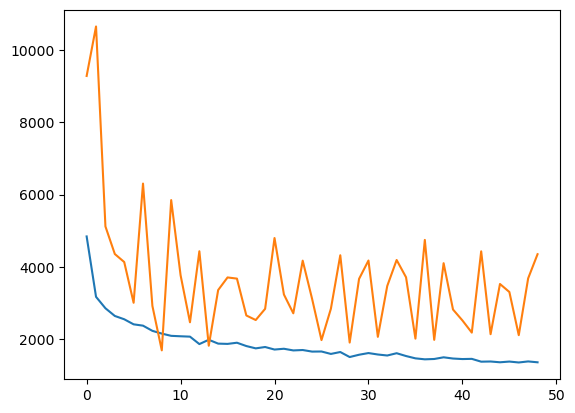

In [113]:
fox = pd.DataFrame(history.history)
fox['loss'].plot()
fox['val_loss'].plot()

In [ ]:
# def ensemble_model_generator(model):
#     X = np.concatenate((X_train_preprocessed,X_val_preprocessed),axis=0)
#     y = np.concatenate((y_train_pre,y_val_pre),axis=0)


#     models = []
#     for i in range(0,3,1):
#         sel_X = X[int(i*0.316*X.shape[0]):int((i+1)*0.316*X.shape[0])]
#         sel_y = y[int(i*0.316*y.shape[0]):int((i+1)*0.316*y.shape[0])]

#         sel_X_val = X[int(i*(0.316+0.05)*X.shape[0]):int((i+1)*(0.316+0.05)*X.shape[0])]
#         sel_y_val = y[int(i*(0.316+0.05)*y.shape[0]):int((i+1)*(0.316+0.05)*y.shape[0])]
#         new_model = model
#         new_model.fit(sel_X,pd.Series(sel_y),
#                 epochs=500, batch_size=60,
#                 validation_data=[sel_X_val, pd.Series(sel_y_val)],
#                 callbacks=tuner_callback, 
#                 verbose=True)        
#         models.append(new_model)
#     models.append(model)
#     return models

# cv_result = ensemble_model_generator(model)


In [ ]:
# def ensemble(models,X):
#     predictions = []
#     for i in range(0,len(models),1):
#         pred_sel = models[i].predict(X)
#         predictions.append(pred_sel)
#     output = np.sum(predictions,axis=0)/len(models)
#     return output

In [ ]:
# cv_result

In [ ]:
# ens_train_pred = ensemble(cv_result, X_train_preprocessed)
# ens_val_pred = ensemble(cv_result, X_val_preprocessed)
# ens_test_pred = ensemble(cv_result, X_test_preprocessed)

<h1> Large  tuner end

In [114]:
# model.fit(X_train_preprocessed, y_train_pre)
train_pred = model.predict(X_train_preprocessed)
val_pred = model.predict(X_val_preprocessed)
test_pred = model.predict(X_test_preprocessed)
forecast = model.predict(X_fore_preprocessed)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


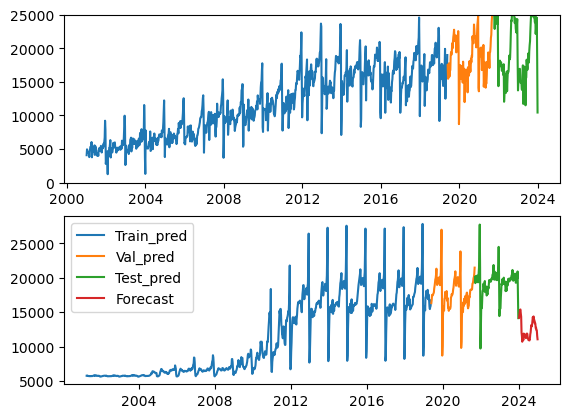

In [115]:
fig,ax = plt.subplots(2)
ax[0].plot(y_train, label='Train')
ax[0].plot(y_val, label='Valid')
ax[0].plot(y_test, label='Test')
ax[0].set_ylim(0,25000)

ax[1].plot(X_train.index[13:], train_pred, label='Train_pred')
ax[1].plot(X_val.index[:], val_pred, label='Val_pred')
ax[1].plot(X_test.index[:], test_pred, label='Test_pred')
ax[1].plot(fdf.index[:], forecast, label='Forecast')
# ax[1].set_ylim(0,35000)

plt.legend()
plt.show()

In [116]:
# from sklearn.metrics import root_mean_squared_error as RMSE
# from sklearn.metrics import mean_absolute_percentage_error as 
from sklearn.metrics import mean_absolute_error as MAE


In [ ]:
# y_train

In [117]:
MAE(y_train_pre, train_pred)

1826.3698336028247

In [118]:
MAE(y_val_pre, val_pred)

1636.1549560546875

In [119]:
MAE(y_test_pre, test_pred)

3235.369970703125

<h2> Residual analysis

In [ ]:
# train_pred

In [121]:
residuals = val_pred.flatten() - y_val_pre

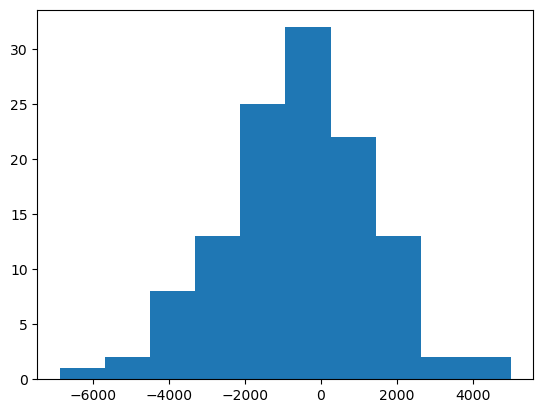

In [122]:
plt.hist(residuals)
plt.show()

In [123]:
my = np.mean(residuals)

In [124]:
std = np.std(residuals)
std

2025.5584328307202

In [125]:
print('lower') 
my- std*1.28

lower


-3169.2260000780097

In [126]:
print('upper') 
my+ std*1.28

upper


2016.2035879686346

In [127]:
std*100

202555.84328307203

In [ ]:
high_list = []
low_list = []
for i in range(0,len(test_pred),1):
    high_sel = test_pred[i][0] + std*(i+1)
    low_sel = test_pred[i][0] - std*(i+1)
    high_list.append(high_sel)
    low_list.append(low_sel)
    

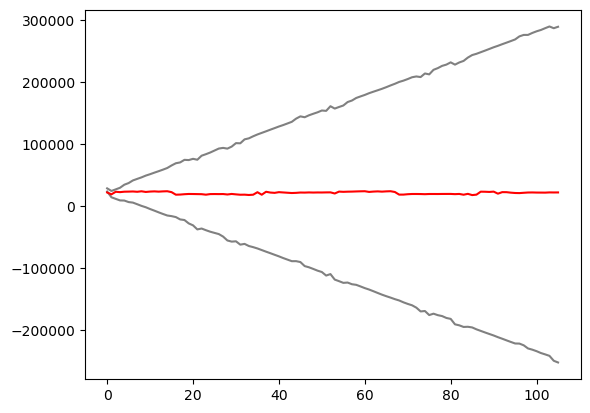

In [ ]:
plt.plot(high_list,color='grey')
plt.plot(low_list, color='grey')
plt.plot(val_pred, color='red')
plt.show()